#### NAVIER STOKES EQUATION 2D
Let $\Omega = (-1 , 1)^2$, $\nu > 0$ and $f \in L^2(\Omega)^2$, $g \in H^{1/2}(\partial\Omega)^2$:

$$
    \begin{cases}
        - \nu \Delta u + (u \cdot \nabla)u + \nabla p &= f  \text{ in } \Omega\\
        \nabla \cdot u &= 0 \text{ in } \Omega\\
        u &= g \text{ on } \partial \Omega\\
        \int_\Omega p dx &= 0
    \end{cases}
$$

#### PDE DATA

$$
    \begin{cases}
        u_1(x, y) &= -sin(\pi x) cos(\pi y),\\
        u_2(x, y) &= cos(\pi x) sin(\pi y),\\
        p(x, y) &= x \exp(\pi y).
    \end{cases}
$$

Thus:

$$
    \begin{split}
        - \nu \Delta u &= 2 \nu \pi^2 \begin{pmatrix} u_1 \\ u_2 \end{pmatrix},\\
        (u \cdot \nabla)u &= \pi cos(\pi x) cos(\pi y) \begin{pmatrix} -u_1 \\ u_2 \end{pmatrix} + \pi sin(\pi x) sin(\pi y) \begin{pmatrix} u_2 \\ -u_1 \end{pmatrix},\\
        \nabla p &= \exp(\pi y) \begin{pmatrix} 1 \\\pi x \end{pmatrix}.
    \end{split}
$$

Thus:

$$
    f = 2 \nu \pi^2 \begin{pmatrix} u_1 \\ u_2 \end{pmatrix} + \pi cos(\pi x) cos(\pi y) \begin{pmatrix} -u_1 \\ u_2 \end{pmatrix} + \pi sin(\pi x) sin(\pi y) \begin{pmatrix} u_2 \\ -u_1 \end{pmatrix} + \exp(\pi y) \begin{pmatrix} 1 \\\pi x \end{pmatrix}.
$$

#### FIRST ORDER FORMULATION
Let $\eta$ the outward pointing unit normal field of $\Omega$:

$$
    \begin{cases}
        \begin{array}{rll}
            - \nu \nabla \cdot U + U u + \nabla p &= f &\text{ in } \Omega,\\
            \nabla \cdot u &= 0 &\text{ in } \Omega,\\
            U - \nabla u &= 0 &\text{ in } \Omega,\\
            \nabla (\text{tr} U) &= 0 &\text{ in } \Omega,\\
            \nabla \times U &= 0 &\text{ in } \Omega,\\
            u &= g &\text{ on } \partial \Omega,\\
            \eta \times U &= \eta \times \nabla g &\text{ on } \partial \Omega,\\
            \int_\Omega p dx &= 0. &
        \end{array}
    \end{cases}
$$

#### EXPERIMENTS
Experiment 1: $\nu = 0.5$, $p = \infty$;

Experiment 2: $\nu = 0.5$, $p = 2$;

In [1]:
import numpy as np
import sys
import scipy as sp
import torch
import json
sys.path.insert(1, 'C:/Users/philh/Notebooks/thesis_framework/')
from differentiation import Differentiation
from cubature import Cubature
from benchmark import Benchmark
from utilities import matmul, data_axes, leg_bary, laplacian, inverse_lu,\
mui_lp_ext, cart, implicit_euler, L, prepare, extract_models

In [2]:
torch.set_default_dtype(torch.float64)
prefix = None #"fof_nse_2D"

#### CUBATURE AND DIFFERENTIATION

In [3]:
# DOMAIN #
deg_d = [10]*2
cuba_d = Cubature(deg_d)
w_d = cuba_d.leja_weights
xs_d = cuba_d.leja_axes
xs_plt_d = cuba_d.axes
bary = cuba_d.leja_axes_bary
diff = Differentiation(xs_d, bary)
dx, dy = diff.nabla
dx2, dy2 = diff.diffs(np.array([[2,0],[0,2]]))

# BOUNDARY #
deg_b = [20]
cuba_b = Cubature(deg_b)
w_b = cuba_b.leja_weights
xs_b = cuba_b.leja_axes
xs_plt_b = cuba_b.axes

#### LAPLACIAN OPERATORS

In [4]:
I = np.eye(len(w_d))
n_d = np.max(deg_d)

W_d = np.diag(w_d)
W_d_inv = np.linalg.inv(W_d)

M_1, M_1_inv = laplacian([dx, dy], [W_d_inv]*2 , [W_d]*2)
M_1_s, _ = laplacian([dx, dy], [W_d_inv]*2, [W_d]*2, weak=True)

M_1_mod = (M_1 + I/n_d**2)
M_1_s_mod = n_d*M_1_s

W_b = np.diag(w_b)

In [5]:
# ABSOLUTE ERROR OF OPERATOR NORM #
print(abs(np.linalg.norm(M_1)-1.0))
print(abs(np.linalg.norm(M_1_s)-1.0))

0.28581340290223545
0.19552397283234502


#### PDE DATA

In [6]:
nu = 0.5

def gt1(x, y):
    return -np.sin(np.pi*x)*np.cos(np.pi*y)

def gt2(x, y):
    return np.cos(np.pi*x)*np.sin(np.pi*y)

def term1(x, y):
    return np.pi*np.cos(np.pi*x)*np.cos(np.pi*y)

def term2(x, y):
    return np.pi*np.sin(np.pi*x)*np.sin(np.pi*y)

def gt3(x, y):
    return x*np.exp(np.pi*y)

def gt11(x, y):
    return -term1(x, y)

def gt12(x, y):
    return term2(x, y)

def gt21(x, y):
    return -term2(x, y)

def gt22(x,y ):
    return term1(x, y)

def f1(x, y):
    return (2*nu*np.pi**2-term1(x,y))*gt1(x, y)+\
            term2(x, y)*gt2(x, y)+\
            np.exp(np.pi*y)
            
def f2(x, y):
    return (2*nu*np.pi**2+term1(x,y))*gt2(x, y)-\
            term2(x, y)*gt1(x, y)+\
            np.exp(np.pi*y)*np.pi*x

#### $l^p$ DEGREE AND BENCHMARK INITIALIZATION

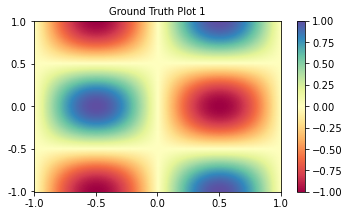

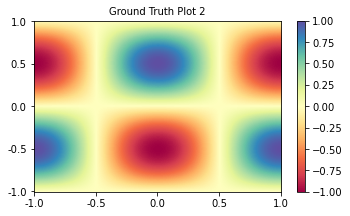

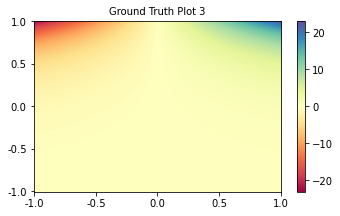

In [7]:
# l^p #
p = 2
mui = mui_lp_ext(deg_d, p)

# BENCHMARK #
test_xs = [np.linspace(-1.0, 1.0, 249)]*2
data = data_axes(test_xs, mui).T
bm = Benchmark([gt1, gt2, gt3], test_xs, data)
_ = bm.eval_gt()
bm.plot_gt(prefix=prefix)

#### REGRESSION UTILITIES

In [8]:
# leja ordered 2d grid in the domain:
grid_d = cuba_d.leja_grid

# corners:
crnrs = np.array([-1.0, 1.0])

# domain and trace evaluation operators w.r.t. chebyshev polynomials:
C_d = data_axes(xs_d, mui).T
C_b = np.concatenate((
    data_axes([xs_b[0], crnrs], mui).T,
    data_axes([crnrs, xs_b[0]], mui).T,
))

# leja ordered 2d grid on the boundary:
grid_b0 = cart([xs_b[0], crnrs])
grid_b1 = cart([crnrs, xs_b[0]])

# ground truth in the first component, evaluated at the boundary:
gt1_b = np.concatenate((
    gt1(grid_b0[:,0], grid_b0[:,1]),
    gt1(grid_b1[:,0], grid_b1[:,1])
))

# ground truth in the second component, evaluated at the boundary:
gt2_b = np.concatenate((
    gt2(grid_b0[:,0], grid_b0[:,1]),
    gt2(grid_b1[:,0], grid_b1[:,1])
))


# additional varibales, evaluated at the boundary:
gt11_b = np.concatenate((
    gt11(grid_b0[:,0], grid_b0[:,1]),
    gt11(grid_b1[:,0], grid_b1[:,1])))


gt12_b = np.concatenate((
    gt12(grid_b0[:,0], grid_b0[:,1]),
    gt12(grid_b1[:,0], grid_b1[:,1])))

gt21_b = np.concatenate((
    gt21(grid_b0[:,0], grid_b0[:,1]),
    gt21(grid_b1[:,0], grid_b1[:,1])))

gt22_b = np.concatenate((
    gt22(grid_b0[:,0], grid_b0[:,1]),
    gt22(grid_b1[:,0], grid_b1[:,1])))


# functions f1, f2 evaluated within the 2d grid of the domain:
f_1 = f1(grid_d[:,0], grid_d[:,1])
f_2 = f2(grid_d[:,0], grid_d[:,1])

#### MAP TO TENSOR

In [9]:
# Cast data, in order to use the torch autograd library.
f_1 = torch.tensor(f_1)
f_2 = torch.tensor(f_2)
gt1_b = torch.tensor(gt1_b)
gt2_b = torch.tensor(gt2_b)
gt11_b = torch.tensor(gt11_b)
gt12_b = torch.tensor(gt12_b)
gt21_b = torch.tensor(gt21_b)
gt22_b = torch.tensor(gt22_b)

#### MULTI LSQ FORMULATION

In [10]:
# In the following part, all equations need to have the same input format.
x = grid_d[:,0]
y = grid_d[:,1]

equations = np.array([
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    -(matmul(dx, U11_d)+matmul(dy,U12_d))+(1/nu)*(U11_d*u1_d+U12_d*u2_d+matmul(dx, p_d)-f_1),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    -(matmul(dx, U21_d)+matmul(dy,U22_d))+(1/nu)*(U21_d*u1_d+U22_d*u2_d+matmul(dy,p_d)-f_2),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    matmul(dx, u1_d)+matmul(dy, u2_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    matmul(np.ones_like(W_d), W_d, p_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    u1_b - gt1_b,\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    u2_b - gt2_b, \
    
    # FOF #
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    U11_d-matmul(dx, u1_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    U12_d-matmul(dy, u1_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    U21_d-matmul(dx, u2_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    U22_d-matmul(dy, u2_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    matmul(dx, U11_d+U22_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    matmul(dy, U11_d+U22_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    -matmul(dy, U11_d)+matmul(dx,U12_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    -matmul(dy, U21_d)+matmul(dx, U22_d),\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    U11_b-gt11_b,\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    U12_b-gt12_b,\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    U21_b-gt21_b,\
    
    lambda u1_d, u2_d, p_d, u1_b, u2_b, U11_d, U12_d, U21_d, U22_d, U11_b, U12_b, U21_b, U22_b:\
    U22_b-gt22_b])

# _l2 | _ | _s | _mod | _s_mod
metrics_fof = [*[W_d]*8, *[W_b]*4]
metrics = np.array([
    [*[W_d]*4, *[W_b]*2, *metrics_fof],
    [*[matmul(W_d, M_1)]*2, *[W_d]*2, *[W_b]*2, *metrics_fof],
    [*[matmul(W_d, M_1_s)]*2, *[W_d]*2, *[W_b]*2, *metrics_fof],
    [*[matmul(W_d, M_1_mod)]*2, *[W_d]*2, *[n_d*W_b]*2, *metrics_fof],
    [*[matmul(W_d, M_1_s_mod)]*2, *[W_d]*2, *[n_d*W_b]*2, *metrics_fof]])

#### TRUNCATION ERROR

In [11]:
# Evaluate all ground truth & fof components and put everything together with the boundary evaluations
# in one array, to obtain the truncation error:
args = [
    torch.tensor(gt1(x, y)), torch.tensor(gt2(x, y)), torch.tensor(gt3(x, y)),
    gt1_b, gt2_b,
    torch.tensor(gt11(x, y)), torch.tensor(gt12(x, y)), torch.tensor(gt21(x, y)), torch.tensor(gt22(x, y)),
    gt11_b, gt12_b, gt21_b, gt22_b]

# _l2 | _ | _s | _mod | _s_mod:
trunc_err_arr = [L(args, np.array([equations.T, metrics[i].T]).T)[0].item() for i in range(5)]
trunc_err = {
    "L_l2": trunc_err_arr[0],
    "L_": trunc_err_arr[1],
    "L_s": trunc_err_arr[2],
    "L_mod": trunc_err_arr[3],
    "L_s_mod": trunc_err_arr[4]
}
print(f'Truncation Errors:\n{json.dumps(trunc_err, indent=5)}')

Truncation Errors:
{
     "L_l2": 2.047926536866119e-06,
     "L_": 9.79184091288735e-07,
     "L_s": 1.000911964424875e-06,
     "L_mod": 9.89943687678963e-07,
     "L_s_mod": 1.2614175636587392e-06
}


#### LINEARISATION

It is sufficient to compute the linearisation of the non-linear part, the linearisation of the linear part is:

$$
    T = \begin{bmatrix}
    -\nu \Delta & 0 & \partial_x\\
    0 & -\nu \Delta & \partial_y
    \end{bmatrix}.
$$


Let $u$ and perturbation $\tau v$:

$$
    \begin{split}
        \begin{bmatrix}
            (u_1+\tau v_1) \partial_x(u_1+\tau v_1) + (u_2+\tau v_2) \partial_y (u_1+\tau v_1)\\
            (u_1+\tau v_1) \partial_x(u_2+\tau v_2) + (u_2+\tau v_2) \partial_y (u_2+\tau v_2)
        \end{bmatrix} -
        \begin{bmatrix}
            u_1 \partial_x u_1 + u_2\partial_y u_1\\
            u_1 \partial_x u_2 + u_2 \partial_y u_2
        \end{bmatrix} = 
        \begin{bmatrix} 
            \tau \partial_x(u_1 v_1) + \tau u_2 \partial_y v_1 + \tau v_2\partial_y u_1 + o(\tau)\\
            \tau \partial_x(u_2 v_2) + \tau u_1 \partial_y v_2 + \tau v_1\partial_y u_2 + o(\tau)
        \end{bmatrix}.
    \end{split}
$$

#### SOLUTION

In [12]:
# hyper parameters for implicit euler method:
theta_0 = torch.zeros(7*len(mui))
tau = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1,  1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
N = 30
print_rate = 5

# define the prepare function (documentation: implicit_euler):
def prep(theta): 
    helper=prepare([C_d, 7], [C_b, 7])(theta)
    return [*helper[0:3], *helper[7:9], *helper[3:7], *helper[10:14]]

# metric (documentation: implicit_euler):
m_l2 = matmul(C_d.T, W_d, C_d)
m_ = matmul(C_d.T, W_d, M_1, C_d)

In [13]:
print(f'cheb_l2:')
cheb_l2, stats_l2 = implicit_euler(
    theta_0,
    m_l2,
    np.array([equations.T, metrics[0].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_l2, indent=5)}')

cheb_l2:
[5]: 0.005110400360617479
[10]: 3.005384047885004e-05
[15]: 3.005384047874898e-05
stats: {
     "iterations": 16,
     "last_loss": 3.0053840478748917e-05,
     "tau_min": 0.0,
     "tau_max": 10000000.0,
     "tau_median": 1.0
}


In [14]:
print(f'cheb_:')
cheb_, stats_ = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[1].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_, indent=5)}')

cheb_:
[5]: 60.12568493054976
[10]: 2.376014250039501e-06
[15]: 2.3760142500307587e-06
[20]: 2.376014250028421e-06
stats: {
     "iterations": 24,
     "last_loss": 2.376014250028421e-06,
     "tau_min": 0.0,
     "tau_max": 10000000.0,
     "tau_median": 0.1
}


In [15]:
print(f'cheb_s:')
cheb_s, stats_s = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[2].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_s, indent=5)}')

cheb_s:
[5]: 13.374920521453387
[10]: 2.416888652040813e-06
[15]: 2.416888652036107e-06
[20]: 2.416888652036107e-06
stats: {
     "iterations": 22,
     "last_loss": 2.416888652036107e-06,
     "tau_min": 0.0,
     "tau_max": 10000000.0,
     "tau_median": 5.5
}


In [16]:
print(f'cheb_mod:')
cheb_mod, stats_mod = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[3].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_mod, indent=5)}')

cheb_mod:
[5]: 63.373255890602046
[10]: 4.565140060976919e-06
[15]: 4.565140060974989e-06
[20]: 4.5651400609749855e-06
[25]: 4.5651400609749855e-06
stats: {
     "iterations": 26,
     "last_loss": 4.5651400609749855e-06,
     "tau_min": 0.0,
     "tau_max": 10000000.0,
     "tau_median": 1000000.0
}


In [17]:
print(f'cheb_s_mod:')
cheb_s_mod, stats_s_mod = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[4].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_s_mod, indent=5)}')

cheb_s_mod:
[5]: 32.609864670238245
[10]: 7.921445443433508e-06
[15]: 7.921445443425268e-06
stats: {
     "iterations": 18,
     "last_loss": 7.921445443425268e-06,
     "tau_min": 0.0,
     "tau_max": 1000000.0,
     "tau_median": 0.55
}


In [18]:
# SET MODELS #
models_l2 = extract_models(cheb_l2, 7)[0:3]
models_ = extract_models(cheb_, 7)[0:3]
models_s = extract_models(cheb_s, 7)[0:3]
models_mod = extract_models(cheb_mod, 7)[0:3]
models_s_mod = extract_models(cheb_s_mod, 7)[0:3]

bm.set_model([*models_l2, *models_, *models_s, *models_mod, *models_s_mod])

#### MODEL EVALUATION AND PLOT

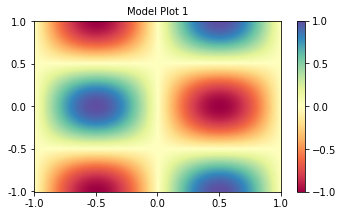

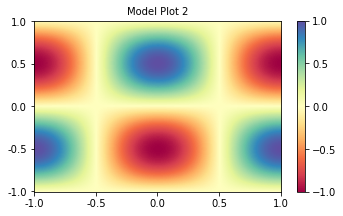

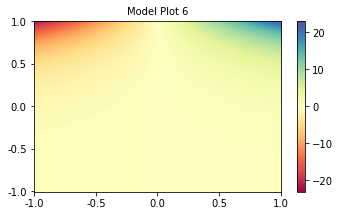

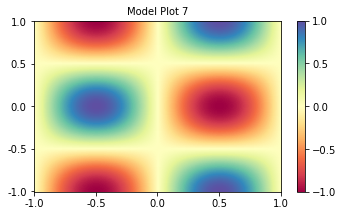

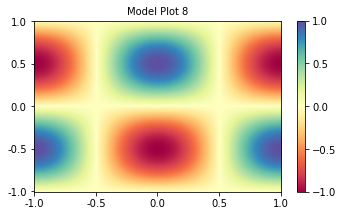

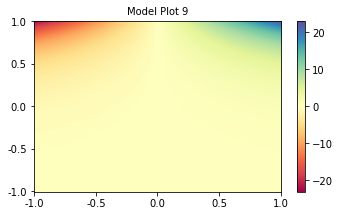

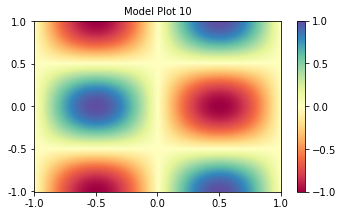

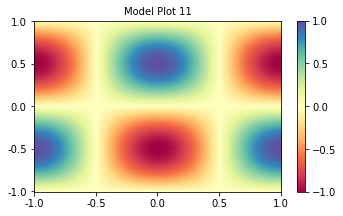

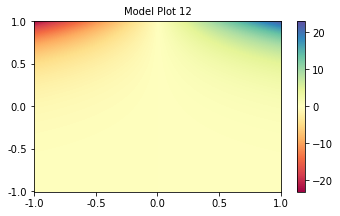

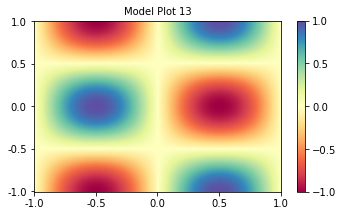

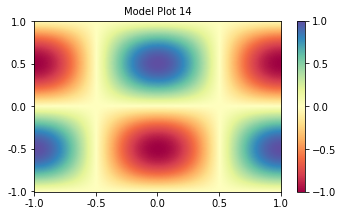

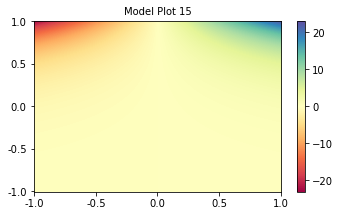

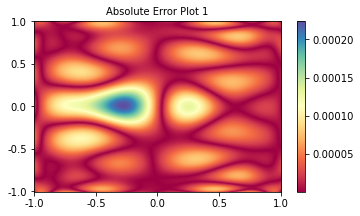

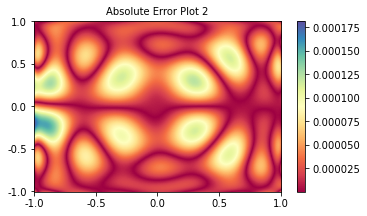

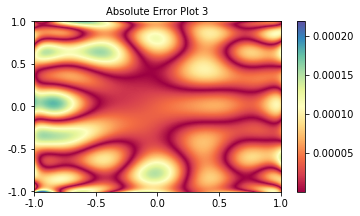

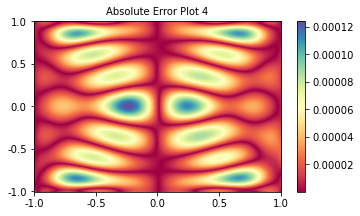

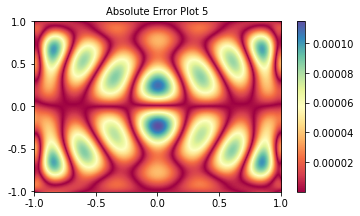

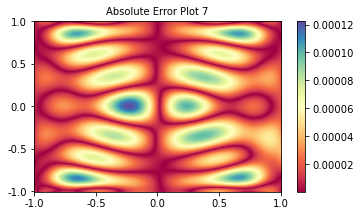

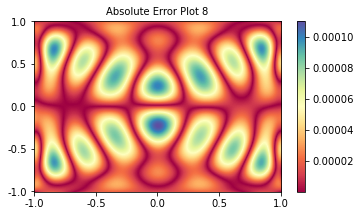

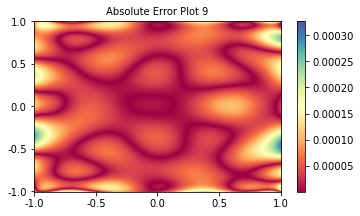

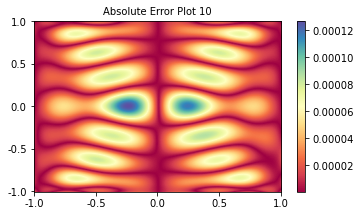

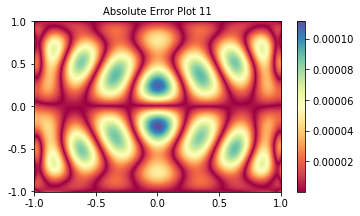

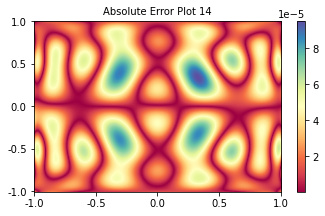

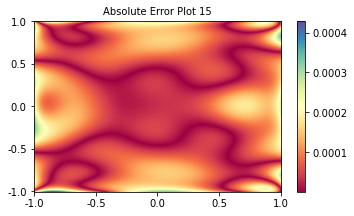

In [19]:
_ = bm.eval_model()
bm.plot_model(prefix=prefix)
bm.plot_abs_err(prefix=prefix)

#### ERRORS

In [20]:
print(f'L1  Error: \n {bm.lp_err(1, precision=3)}')
print(f'L2  Error: \n {bm.lp_err(2, precision=3)}')
print(f'Max Error: \n {bm.lp_err(np.inf, precision=3)}')

L1  Error: 
 ['3.58e-05', '3.657e-05', '4.928e-05', '3.108e-05', '3.061e-05', '3.272e-05', '3.187e-05', '3.066e-05', '4.645e-05', '2.926e-05', '2.942e-05', '3.125e-05', '2.721e-05', '2.751e-05', '7.66e-05']
L2  Error: 
 ['5.181e-05', '4.808e-05', '6.124e-05', '4.069e-05', '3.977e-05', '4.386e-05', '4.118e-05', '3.931e-05', '6.219e-05', '3.824e-05', '3.815e-05', '4.012e-05', '3.506e-05', '3.435e-05', '9.725e-05']
Max Error: 
 ['2.247e-04', '1.82e-04', '2.191e-04', '1.245e-04', '1.154e-04', '2.442e-04', '1.229e-04', '1.103e-04', '3.281e-04', '1.273e-04', '1.118e-04', '1.485e-04', '9.843e-05', '9.531e-05', '4.300e-04']


#### TABLE FORMAT ERROR

In [21]:
err=np.array(
    [bm.lp_err(2, precision=2),
     bm.lp_err(np.inf, precision=2)])

row = f'{deg_d[0]} '
err_u_1 = np.array([err[0][0::3],err[1][0::3]])
for _ in err_u_1.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'
print(row)

row = f'{deg_d[0]} '
err_u_2 = np.array([err[0][1::3],err[1][1::3]])
for _ in err_u_2.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'
print(row)

row = f'{deg_d[0]} '
err_p = np.array([err[0][2::3],err[1][2::3]])
for _ in err_p.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'
print(row)

10 & 5.18e-05 & 2.25e-04 & 4.07e-05 & 1.24e-04 & 4.12e-05 & 1.23e-04 & 3.82e-05 & 1.27e-04 & 3.51e-05 & 9.84e-05 \\
10 & 4.81e-05 & 1.82e-04 & 3.98e-05 & 1.15e-04 & 3.93e-05 & 1.10e-04 & 3.81e-05 & 1.12e-04 & 3.43e-05 & 9.53e-05 \\
10 & 6.12e-05 & 2.19e-04 & 4.39e-05 & 2.44e-04 & 6.22e-05 & 3.28e-04 & 4.01e-05 & 1.48e-04 & 9.73e-05 & 4.30e-04 \\
